In [1]:
import math
import random
from shutil import move
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# Initializing Training data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)), transforms.RandomHorizontalFlip()])

full_dataset = datasets.FashionMNIST(
   root = 'data',
   train = True,
   download = True,
   transform = transform
)

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

# split out training, test, and validation datasets
train, test, valid = random_split(full_dataset, [48000, 6000, 6000 ])

# initialize dataloaders for training and testing

training_loader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=5, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=5, shuffle=False)



100%|██████████| 26421880/26421880 [00:01<00:00, 15624705.70it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305566.03it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5472345.68it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19382654.39it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



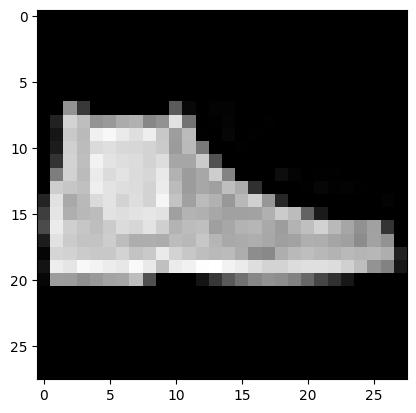

Label: 9


In [3]:
# viewing training loader sample
train_features, train_labels = next(iter(training_loader))
img = train_features[4].squeeze()
label = train_labels[4]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

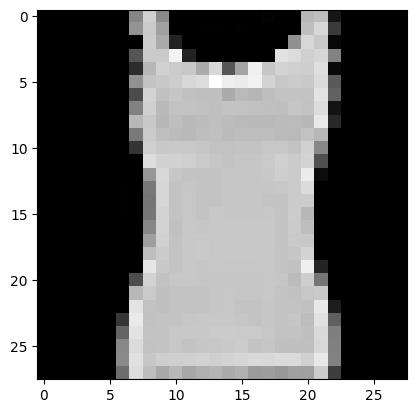

Label: 0


In [4]:
# viewing validation loader sample
valid_features, valid_labels = next(iter(valid_loader))
img = valid_features[4].squeeze()
label = valid_labels[4]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

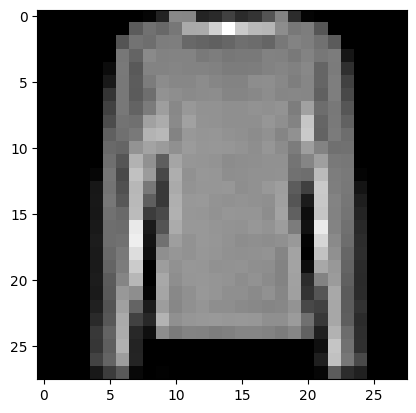

Label: 2


In [5]:
# viewing test loader sample
test_features, test_labels = next(iter(test_loader))
img = test_features[4].squeeze()
label = test_labels[4]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

<function matplotlib.pyplot.show(close=None, block=None)>

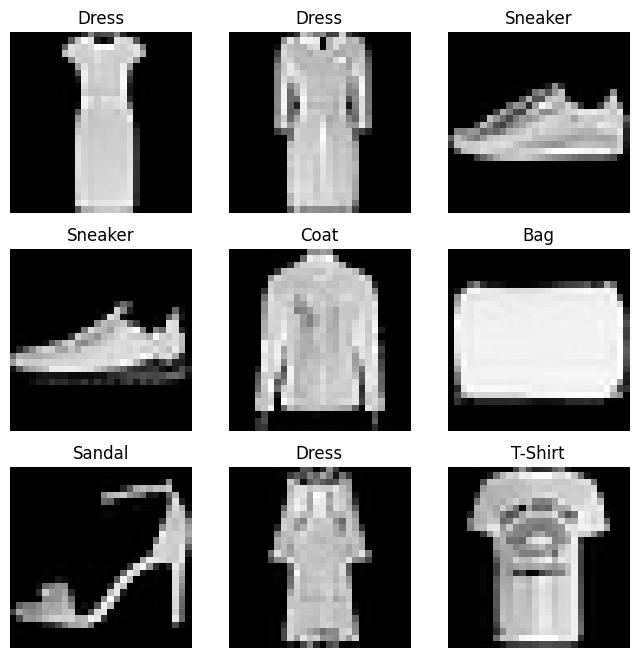

In [6]:
# take a look at the full full dataset
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(full_dataset), size=(1,)).item()
  img, label = full_dataset[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap='gray')
plt.show

In [7]:
fashion_classifier = nn.Sequential( #
    nn.Conv2d(1, 16, 3, 1, 1), # output feature map will be a 28*28 map with 16 features
    nn.MaxPool2d(3, 1), # output will be a 26 * 26 feature map with 16 features
    nn.ReLU(), # adding a Rectified Linear Unit to introduce nonlinearity to the model
    nn.Conv2d(16, 32, 5, 1, 1), # 24 * 24 with 32 features
    nn.MaxPool2d(5, 1), # 20 * 20 with 32 features
    nn.ReLU(),
    nn.Dropout(),
    nn.Flatten(), # flattens the output from the convolutional layer so it can be fed to the linear output layer for classification
    nn.Linear(12800, 10) # maps feature outputs from the convolutional layer to the desired classification set (i.e. which article of clothing appears in the image) using a linear equation
)

In [8]:
optimizer = torch.optim.SGD(fashion_classifier.parameters(), lr=0.001, momentum=0.9)

In [9]:
loss_func = nn.CrossEntropyLoss()

In [10]:
# use a gpu if it's available - this makes training MUCH faster
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
fashion_classifier.to(device)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=12800, out_features=10, bias=True)
)

In [11]:
def train_loop(model, training_data, validation_data, loss_func):
  # iterate over dataloader batches
  model.train()

  for x, y in training_data:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad() # zero out existing gradients
    prediction = model(x) # make predictions
    loss = loss_func(prediction, y) # calculate the loss
    loss.backward() # apply backpropogation to each node / layer
    optimizer.step() # step parameters based on calculated error gradient
  model.eval()
  avg_loss = []
  for i, j in validation_data: # validator test loop - seeing how good the model performs after looping through the training set and updating weights
    i, j = i.to(device), j.to(device)
    validator_predictions = model(i)
    loss = loss_func(validator_predictions, j)
    avg_loss.append(loss)
  loss_tensor = torch.tensor(avg_loss)
  print('validation loss:', (loss_tensor.sum() / len(loss_tensor)))
  return

In [12]:
# can use this to test the train loop function
#train_loop(fashion_classifier, training_loader, loss_func)

In [13]:
for i in range(0,9):
  print('epoch', i)
  train_loop(fashion_classifier, training_loader, valid_loader, loss_func)

epoch 0
validation loss: tensor(0.3593)
epoch 1
validation loss: tensor(0.3027)
epoch 2
validation loss: tensor(0.3146)
epoch 3
validation loss: tensor(0.3156)
epoch 4
validation loss: tensor(0.2838)
epoch 5
validation loss: tensor(0.2953)
epoch 6
validation loss: tensor(0.2994)
epoch 7
validation loss: tensor(0.2953)
epoch 8
validation loss: tensor(0.2681)


In [14]:
# I used the code below for testing predictions on individual batches, was useful for troubleshooting and debugging
# input = next(iter(valid_loader))
# features, label = input
# print(input)
# output = torch.max(fashion_classifier(input[0]), 1)
# print(output)

In [15]:
def accuracy_test(model, data_loader):
  model.eval()
  total_predictions = 0
  correct_predictions = 0
  for images, labels in data_loader:
    images, labels = images.to(device), labels.to(device)
    predictions = torch.max(model(images), 1)
    batch_results = predictions[1] == labels
    correct = batch_results.sum()
    correct_predictions += correct.item()
    total_predictions += len(images)
  return correct_predictions / total_predictions
accuracy_test(fashion_classifier, test_loader)

0.9025